In [1]:
import os
import sys
sys.path.append('../../../src')
import time
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnchoredOffsetbox
from tqdm import tqdm # progress bar

## some parameters

In [2]:
batch_size = 32
learning_rate = 1e-4
momentum = 0.9
epochs = 15

## only use dataset and dataloader from pytorch
tensors loaded using `pytorch` will be converted to `tortto` tensors later.

In [3]:
from numpy.random import choice
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor, Normalize, Resize

In [4]:
dataset_path = '../../cifar10_data'
img_mean = (0.485, 0.456, 0.406)
img_sd = (0.229, 0.224, 0.225)
transform_aug = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    Resize((224,224)),
    ToTensor(),
    Normalize(img_mean, img_sd),
])

transform = Compose([
    Resize((224,224)),
    ToTensor(),
    Normalize(img_mean, img_sd),
])
# create datasets
train_dataset = CIFAR10(root=dataset_path, train=True, download=True, transform=transform_aug)
val_dataset = CIFAR10(root=dataset_path, train=True, download=True, transform=transform)
test_dataset = CIFAR10(root=dataset_path, train=False, download=True, transform=transform)

# create dataloaders
indices = choice(50_000, size=50_000, replace=False)
train_idx, val_idx = indices[:45_000], indices[45_000:]
train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('size of train set', len(train_idx))
print('size of validation set', len(val_idx))
print('size of test set', len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
size of train set 45000
size of validation set 5000
size of test set 10000


## the rest is done in pytortto

In [5]:
import tortto as tt
import tortto.nn as nn
import tortto.nn.functional as F
import tortto.optim as optim

## define a network

In [6]:
def conv3x3(in_channels, channels, stride=1):
    return nn.Conv2d(in_channels, channels, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_channels, channels, stride=1):
    return nn.Conv2d(in_channels, channels, kernel_size=1, stride=stride, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, channels, stride=1, downsample=None):
        """
        in_channels: number of incoming channels.
        channels: number of channels in the first layer of this block
        """
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(in_channels, channels)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = conv3x3(channels, channels, stride)
        self.bn2 = nn.BatchNorm2d(channels)
        self.conv3 = conv1x1(channels, channels * self.expansion)
        self.bn3 = nn.BatchNorm2d(channels * self.expansion)

        self.downsample = downsample

    def forward(self, x):
        """
        x---conv1,bn1,relu-->conv2,bn2,relu-->conv3,bn3---relu-->
          |_____________ downsample_____________________|
        """
        shortcut = x if self.downsample is None else self.downsample(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        return F.relu(out + shortcut)


class ResNet(nn.Module):
    def __init__(self, block, layers, channels):
        """
        layers: number of residual blocks in each layer
        channels: number of channels
        """
        super(ResNet, self).__init__()
        self.in_channels = channels[0]
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)  # in_channels will increase accordingly after each _make_layer call
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, channels[0], layers[0])
        self.layer2 = self._make_layer(block, channels[1], layers[1], stride=2)
        self.layer3 = self._make_layer(block, channels[2], layers[2], stride=2)
        self.layer4 = self._make_layer(block, channels[3], layers[3], stride=2)


    def _make_layer(self, block, channels, blocks, stride=1):
        downsample = nn.Sequential()
        # for the first block of conv2_x, if bottleneck is used, there will be increase of channels
        # so we need downsample
        if stride != 1 or self.in_channels != channels * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_channels, channels * block.expansion, stride),
                nn.BatchNorm2d(channels * block.expansion)
            )

        # append the first block in the layer
        layers = [block(self.in_channels, channels, stride, downsample)]
        self.in_channels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels)  # stride=1
            )
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = tt.mean(x, (-1, -2), True)
        x = tt.flatten(x, 1)
        
        x = F.log_softmax(self.classifier(x), -1)
        
        return x

def resnet50():
    return ResNet(Bottleneck, [3, 4, 6, 3], [64, 128, 256, 512])

In [7]:
net = resnet50()
net.load_state_dict(tt.load('models/resnet50.npy'))
net.classifier = nn.Linear(2048,10)
net = net.cuda()
print(f'total trainable parameters: {sum(_.numel() for _ in net.parameters())/1e6:.2f} million')

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

total trainable parameters: 23.53 million


## define functions for training and validation

In [8]:
def calculate_loss(batch, correct, total):
    inputs, labels = batch
    
    # convert pytorch tensor to tortto tensor
    inpt = tt.tensor(inputs.numpy()).cuda()
    lab = tt.tensor(labels.numpy()).cuda()
    
    # forward
    outputs = net(inpt)
    loss = criterion(outputs, lab)
    
    # prediction
    predicted = outputs.argmax(-1)
    correct += (predicted == lab).sum().item()
    total += lab.shape[0]
    
    return loss, correct, total
    
    
def train():
    # train
    net.train()
    correct = 0
    total = 0
    loop = tqdm(train_loader)
    train_loss = 0
    for i, batch in enumerate(loop):

        # zero the parameter gradients
        optimizer.zero_grad()

        loss, correct, total = calculate_loss(batch, correct, total)
        
        # accumulate loss
        train_loss += loss.item()
        
        # backpropagation
        loss.backward()

        # update parameters
        optimizer.step()

    # keep track of train loss and train error
    loss_history['train'].append(train_loss / (i + 1))
    error_history['train'].append(100 * (1. - correct / total))
    

@tt.no_grad()
def val_test(dataloader):
    net.eval()
    correct = 0
    total_sample = 0
    total_loss = 0
    loop = tqdm(dataloader)
    for i, batch in enumerate(loop):
        
        # cal loss
        loss, correct, total_sample = calculate_loss(batch, correct, total_sample)
        
        # accumulate val loss
        total_loss += loss.item()
    
    avg_loss = total_loss / (i + 1)
    avg_error = 100 * (1. - correct / total_sample)
    return avg_loss, avg_error

    
def save():
    global lowest_error
    # save checkpoint
    if error_history['val'][-1] < lowest_error:
        checkpoint = {
            'model': net.state_dict()
            }
        tt.save(checkpoint, f'models/checkpoint_{str(epoch).zfill(3)}.npy')
        lowest_error = error_history['val'][-1]
    
    # save loss, error history and log
    tt.save(loss_history, 'logs/loss_history.npy')
    tt.save(error_history, 'logs/error_history.npy')
    with open('logs/log.txt','a') as f:
        f.write('epoch{} finished at {}. val_loss: {:.4f} - val_error: {:.2f}%\n'.
                format(str(epoch).zfill(3), 
                       datetime.now().strftime("%m/%d/%Y, %H:%M:%S"), 
                       loss_history['val'][-1], 
                       error_history['val'][-1]))

## start training

In [9]:
loss_history = {'train': [], 'val': []}
error_history = {'train': [], 'val': []}

if os.path.exists('logs/log.txt'):
    raise OSError('Previous training logs already exist.')

lowest_error = 100
for epoch in range(epochs):
    
    # train
    train()
    
    # validation
    val_loss, val_error = val_test(val_loader)
    loss_history['val'].append(val_loss)
    error_history['val'].append(val_error)
    print(' - val_loss: {:.4f} - val_error: {:.2f}%\n'.format(loss_history['val'][-1], val_error))
    
    # save
    save()

100%|██████████| 157/157 [00:33<00:00,  4.67it/s]


 - val_loss: 0.3619 - val_error: 9.82%



100%|██████████| 157/157 [00:33<00:00,  4.65it/s]


 - val_loss: 0.2204 - val_error: 6.60%



100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


 - val_loss: 0.1738 - val_error: 5.50%



100%|██████████| 157/157 [00:33<00:00,  4.67it/s]


 - val_loss: 0.1498 - val_error: 4.74%



100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


 - val_loss: 0.1358 - val_error: 4.24%



100%|██████████| 157/157 [00:33<00:00,  4.65it/s]


 - val_loss: 0.1300 - val_error: 4.34%



100%|██████████| 157/157 [00:33<00:00,  4.67it/s]


 - val_loss: 0.1267 - val_error: 4.08%



100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


 - val_loss: 0.1153 - val_error: 3.66%



100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


 - val_loss: 0.1100 - val_error: 3.58%



100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


 - val_loss: 0.1144 - val_error: 3.62%



100%|██████████| 157/157 [00:33<00:00,  4.67it/s]


 - val_loss: 0.1113 - val_error: 3.74%



100%|██████████| 157/157 [00:33<00:00,  4.67it/s]


 - val_loss: 0.1035 - val_error: 3.32%



100%|██████████| 157/157 [00:33<00:00,  4.67it/s]


 - val_loss: 0.1042 - val_error: 3.34%



100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


 - val_loss: 0.1035 - val_error: 3.32%



100%|██████████| 157/157 [00:33<00:00,  4.67it/s]


 - val_loss: 0.1045 - val_error: 3.26%



## plot loss and error

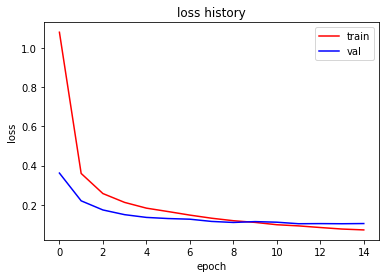

In [10]:
loss_history = tt.load('logs/loss_history.npy')
plt.plot(loss_history['train'], 'r', label='train')
plt.plot(loss_history['val'], 'b', label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss history')
plt.legend()
plt.show()

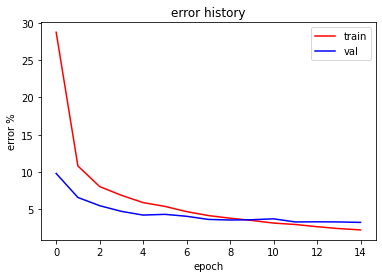

In [11]:
error_history = tt.load('logs/error_history.npy')
plt.plot(error_history['train'], 'r', label='train')
plt.plot(error_history['val'], 'b', label='val')
plt.xlabel('epoch')
plt.ylabel('error %')
plt.title('error history')
plt.legend()
plt.show()

## evaluation on test set

In [12]:
# load checkpoint with the lowest validation error
checkpoint = tt.load('models/checkpoint_014.npy')
net.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [13]:
_, test_error = val_test(test_loader)
print(f'Test error: {test_error:.2f}%')

100%|██████████| 313/313 [01:07<00:00,  4.65it/s]

Test error: 3.69%
